# Machine Learning Pipeline: Salary Estimation & Role Classification

This notebook implements the training pipeline for two models:
1. **Salary Estimator (XGBoost Regressor)**: Predicts annual compensation based on skills, experience, and location.
2. **Role Classifier (Random Forest)**: Predicts standardized job roles based on raw text descriptions.

In [59]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score, f1_score, classification_report, confusion_matrix
import xgboost as xgb
import os
from scipy.sparse import hstack, csr_matrix

# Configuration
DATA_PATH = '../../data/hn_jobs_structured.parquet'
ARTIFACTS_DIR = '.'
TOP_N_TECH = 50
MAX_TEXT_FEATURES = 2000

# Set visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded.")

Libraries loaded.


In [60]:
# Load Data
try:
    df = pd.read_parquet(DATA_PATH)
    print(f"Successfully loaded {len(df)} rows.")
    display(df.head(3))
except FileNotFoundError:
    print(f"Error: File not found at {DATA_PATH}. Please check the path.")

Successfully loaded 37115 rows.


,id,date,raw_text,company_name,role_title,salary_min,salary_max,salary_avg,currency,is_remote,...,is_tier_1_city,is_europe,is_global_remote,is_yc,is_funded,is_crypto,has_equity,offers_visa,tech_combo_ai,tech_combo_blockchain
0,21937030,2020-01-01,"CodeWeavers | St Paul, MN, USA | Full Time | R...",CodeWeavers,"St Paul, MN, USA",<NA>,<NA>,<NA>,None,True,...,False,False,False,False,False,False,False,True,False,False
1,21937183,2020-01-01,GiveCampus (YC S15) | software engineers | Ful...,GiveCampus (YC S15),software engineers,<NA>,<NA>,<NA>,None,False,...,False,False,False,True,True,False,True,False,False,False
2,21937418,2020-01-01,"Citymapper | Full-time, VISA and Remote (for e...",Citymapper,"Full-time, VISA and Remote (for experienced ca...",<NA>,<NA>,<NA>,None,True,...,True,True,False,False,False,False,False,True,False,False


## 1. Feature Engineering

We need to convert raw data into a numerical matrix.
* **Tech Stack**: One-Hot Encoding for top 50 technologies.
* **Booleans**: Convert True/False to 1/0.
* **Missing Values**: Impute `years_experience`.

In [61]:
def preprocess_features(df):
    print("Preprocessing features...")
    
    # A. Categorical Encoding - Tech Stack
    # Flatten all tech stacks to find top 50
    all_techs = [tech for sublist in df['tech_stack'] if sublist is not None for tech in sublist]
    top_50_tech = pd.Series(all_techs).value_counts().head(TOP_N_TECH).index.tolist()
    print(f"Top 5 Techs: {top_50_tech[:5]}")
    
    # Create columns for top 50 tech
    for tech in top_50_tech:
        safe_tech_name = f"tech_{tech.lower().replace(' ', '_').replace('.', '')}"
        df[safe_tech_name] = df['tech_stack'].apply(lambda x: 1 if x is not None and tech in x else 0)
        
    # B. Boolean Normalization
    bool_cols = [
        'is_remote', 'is_senior', 'is_funded', 'is_crypto', 
        'is_junior', 'is_manager', 'is_tier_1_city', 'is_europe', 
        'is_global_remote', 'is_yc', 'has_equity', 'offers_visa',
        'tech_combo_ai', 'tech_combo_blockchain'
    ]
    for col in bool_cols:
        if col in df.columns:
            df[col] = df[col].fillna(False).astype(int)
            
    # C. Handling Missing Data - years_experience
    if 'years_experience' in df.columns:
        df['years_experience'] = df['years_experience'].fillna(-1)
        
    return df, top_50_tech

df_processed, top_techs = preprocess_features(df.copy())
print("Feature engineering complete.")

Preprocessing features...
Top 5 Techs: ['JavaScript', 'React', 'Python', 'SQL', 'AWS']
Feature engineering complete.
Feature engineering complete.


## 2. Model A: Salary Estimator (XGBoost)

* **Target**: `salary_avg`
* **Algorithm**: XGBoost Regressor
* **Metrics**: MAE, R2

In [54]:
# Filter Data for Salary Model
salary_data = df_processed[df_processed['salary_avg'].notnull()].copy()

# Filter for USD only to reduce noise
if 'currency' in salary_data.columns:
    print(f"Original currency distribution:\n{salary_data['currency'].value_counts().head()}")
    salary_data = salary_data[salary_data['currency'] == 'USD']

# Remove outliers ($10k - $500k)
salary_data = salary_data[(salary_data['salary_avg'] > 10000) & (salary_data['salary_avg'] < 500000)]
print(f"Training samples after filtering: {len(salary_data)}")

# --- IMPROVEMENT 1: Granular Seniority Features ---
# Extract specific high-value keywords that imply higher pay bands
high_value_keywords = ['staff', 'principal', 'architect', 'lead', 'head', 'director', 'vp', 'founding']
for kw in high_value_keywords:
    # Check both raw_text and role_title if available
    salary_data[f'is_{kw}'] = salary_data['raw_text'].fillna('').str.lower().str.contains(rf'\b{kw}\b').astype(int)

# --- IMPROVEMENT 2: Log Transformation ---
# Create log-transformed target
salary_data['log_salary'] = np.log1p(salary_data['salary_avg'])

# Feature Engineering
# 1. One-Hot Encode Job Category
if 'job_category' in salary_data.columns:
    print("Encoding job_category...")
    role_dummies = pd.get_dummies(salary_data['job_category'], prefix='cat')
    salary_data = pd.concat([salary_data, role_dummies], axis=1)

# 2. Define Numeric/Boolean Features
exclude_cols = ['id', 'date', 'raw_text', 'company_name', 'role_title', 
                'salary_min', 'salary_max', 'salary_avg', 'log_salary', 'currency', 
                'tech_stack', 'job_category']
feature_cols = [c for c in salary_data.columns if c not in exclude_cols]

# 3. Prepare Numeric Matrix
X_numeric = salary_data[feature_cols].fillna(0).astype(float).values

# 4. Text Features (TF-IDF)
print("Vectorizing text for salary model...")
tfidf_salary = TfidfVectorizer(
    max_features=1000, 
    stop_words='english', 
    token_pattern=r'(?u)\b[a-zA-Z][a-zA-Z]+\b'
)
X_text = tfidf_salary.fit_transform(salary_data['raw_text'].fillna(''))

# Combine
print(f"Combining Numeric ({X_numeric.shape}) and Text ({X_text.shape}) features...")
X = hstack([csr_matrix(X_numeric), X_text])
y = salary_data['log_salary'] # Training on Log Salary

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
print("Training XGBoost Regressor (on Log Salary)...")
salary_model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=8,
    learning_rate=0.03,
    subsample=0.7,
    colsample_bytree=0.7,
    objective='reg:squarederror', # Squared error is standard for log-space regression
    n_jobs=-1,
    random_state=42
)
salary_model.fit(X_train, y_train)

# Predict
y_pred_log = salary_model.predict(X_test)

# Inverse Transform (Convert back to Dollars)
y_pred = np.expm1(y_pred_log)
y_test_dollars = np.expm1(y_test)

# Evaluate
mae = mean_absolute_error(y_test_dollars, y_pred)
r2 = r2_score(y_test_dollars, y_pred)

print(f"MAE: ${mae:,.2f}")
print(f"R2 Score: {r2:.4f}")

Original currency distribution:
currency
USD    4871
EUR     598
GBP     396
Name: count, dtype: int64
Training samples after filtering: 3868
Encoding job_category...
Vectorizing text for salary model...
Encoding job_category...
Vectorizing text for salary model...
Combining Numeric ((3868, 60)) and Text ((3868, 1000)) features...
Training XGBoost Regressor (on Log Salary)...
Combining Numeric ((3868, 60)) and Text ((3868, 1000)) features...
Training XGBoost Regressor (on Log Salary)...
MAE: $37,316.60
R2 Score: 0.3749
MAE: $37,316.60
R2 Score: 0.3749


C:\Users\dell\AppData\Local\Temp\ipykernel_3244\2556701389.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_imp, palette='viridis')


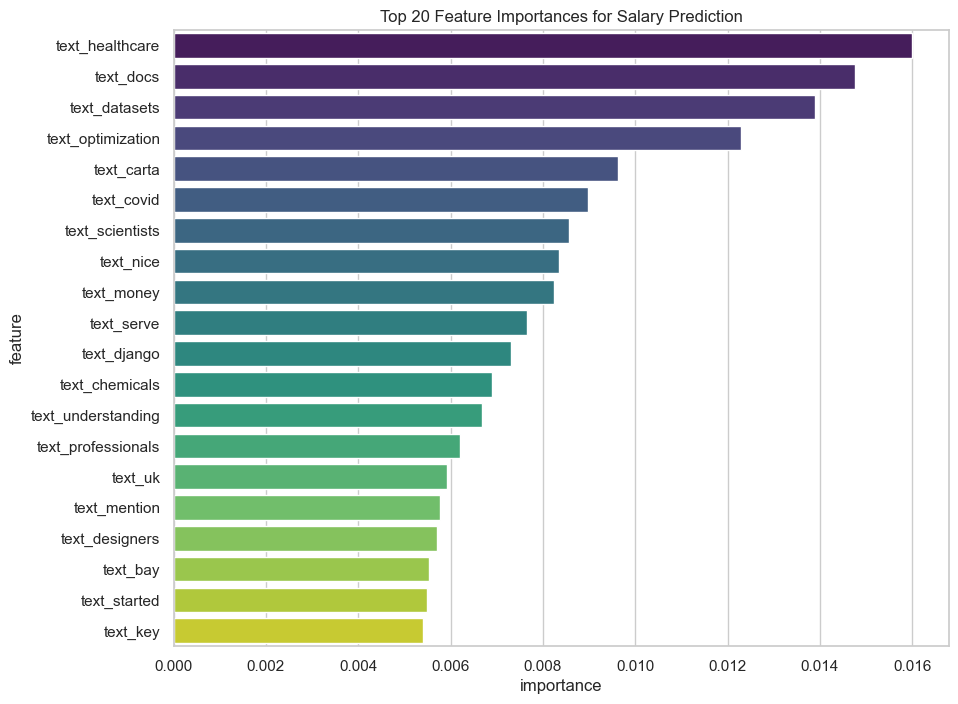

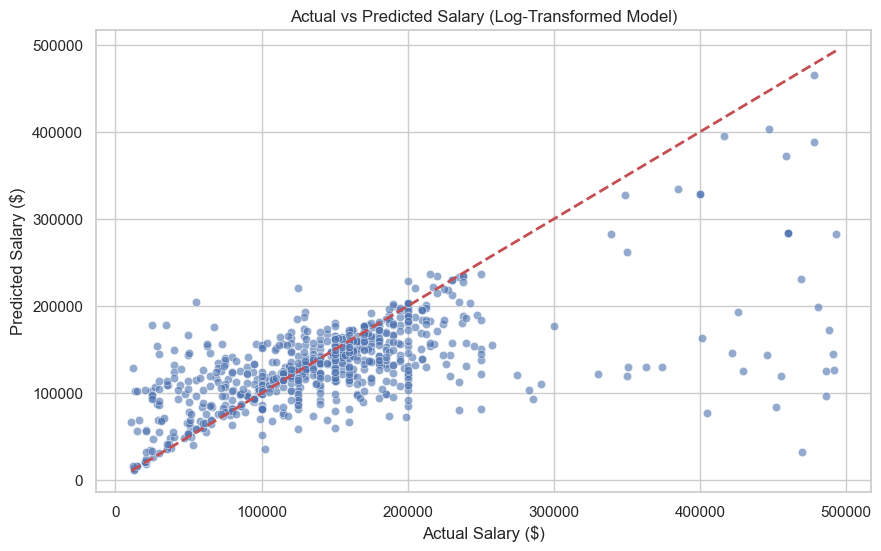

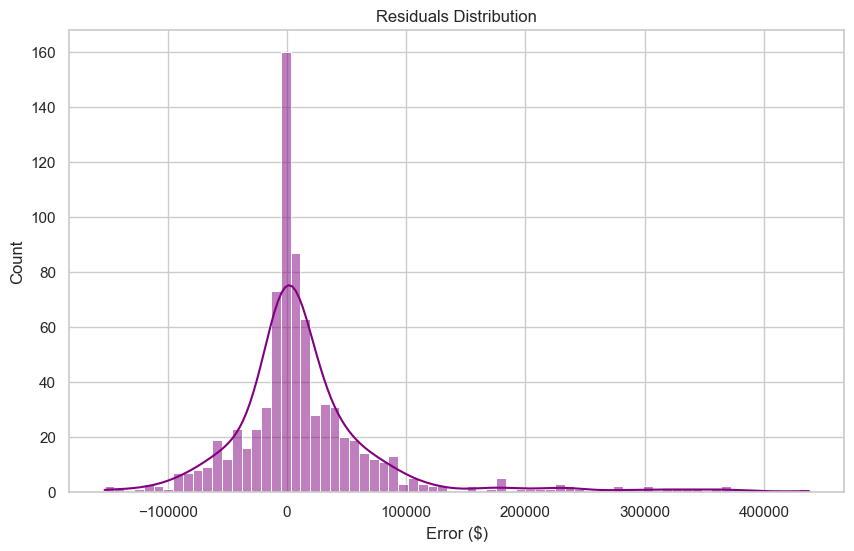

In [55]:
# Visualizations for Salary Model

# 1. Feature Importance
text_features = [f"text_{w}" for w in tfidf_salary.get_feature_names_out()]
all_feature_names = feature_cols + text_features

importance = salary_model.feature_importances_
feature_imp = pd.DataFrame({'feature': all_feature_names, 'importance': importance})
feature_imp = feature_imp.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_imp, palette='viridis')
plt.title('Top 20 Feature Importances for Salary Prediction')
plt.show()

# 2. Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_dollars, y=y_pred, alpha=0.6)
plt.plot([y_test_dollars.min(), y_test_dollars.max()], [y_test_dollars.min(), y_test_dollars.max()], 'r--', lw=2)
plt.xlabel('Actual Salary ($)')
plt.ylabel('Predicted Salary ($)')
plt.title('Actual vs Predicted Salary (Log-Transformed Model)')
plt.show()

# 3. Residuals
residuals = y_test_dollars - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='purple')
plt.title('Residuals Distribution')
plt.xlabel('Error ($)')
plt.show()

## 3. Model B: Role Classifier (Random Forest)

* **Target**: `job_category`
* **Features**: TF-IDF (Text) + Tech Stack (Explicit)
* **Metrics**: F1-Score, Confusion Matrix

In [56]:
# Filter Data for Role Model
role_data = df_processed[df_processed['job_category'].notnull()].copy()
print(f"Role Classification Samples: {len(role_data)}")

# TF-IDF Vectorization
print("Vectorizing text...")
tfidf = TfidfVectorizer(max_features=MAX_TEXT_FEATURES, stop_words='english')
tfidf_matrix = tfidf.fit_transform(role_data['raw_text'].fillna(''))

# Numeric Features (Tech Stack columns)
tech_cols = [c for c in role_data.columns if c.startswith('tech_') and c != 'tech_stack']
X_numeric = role_data[tech_cols].fillna(0).astype(float).values

# Combine Features
print(f"Combining TF-IDF ({tfidf_matrix.shape}) and Numeric ({X_numeric.shape}) features...")
X_role = hstack([tfidf_matrix, csr_matrix(X_numeric)])
y_role = role_data['job_category']

# Split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_role, y_role, test_size=0.2, random_state=42)

# Train
print("Training Random Forest Classifier...")
role_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
role_model.fit(X_train_r, y_train_r)

# Predict
y_pred_r = role_model.predict(X_test_r)

# Evaluate
f1 = f1_score(y_test_r, y_pred_r, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_r, y_pred_r))

Role Classification Samples: 37115
Vectorizing text...
Combining TF-IDF ((37115, 2000)) and Numeric ((37115, 32)) features...
Training Random Forest Classifier...
Combining TF-IDF ((37115, 2000)) and Numeric ((37115, 32)) features...
Training Random Forest Classifier...
Weighted F1 Score: 0.8478

Classification Report:
              precision    recall  f1-score   support

     Backend       0.92      0.43      0.59       349
     Data/AI       0.86      1.00      0.92      5771
      DevOps       0.94      0.44      0.60       484
    Frontend       0.95      0.42      0.59       357
   Fullstack       1.00      0.40      0.57        10
     General       0.79      0.40      0.53       268
      Mobile       0.99      0.40      0.57       184

    accuracy                           0.87      7423
   macro avg       0.92      0.50      0.62      7423
weighted avg       0.88      0.87      0.85      7423

Weighted F1 Score: 0.8478

Classification Report:
              precision    recal

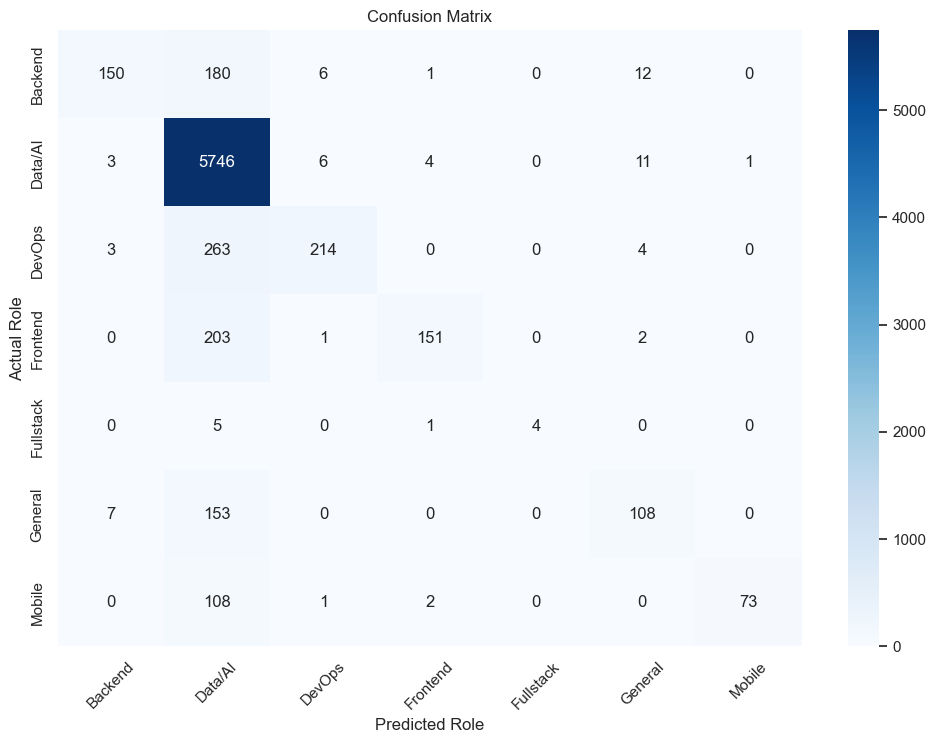

In [57]:
# Visualizations for Role Model

# Confusion Matrix
cm = confusion_matrix(y_test_r, y_pred_r)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=role_model.classes_, 
            yticklabels=role_model.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual Role')
plt.xlabel('Predicted Role')
plt.xticks(rotation=45)
plt.show()

In [58]:
# Save Artifacts
print("Saving models...")
with open(os.path.join(ARTIFACTS_DIR, 'salary_model.pkl'), 'wb') as f:
    pickle.dump(salary_model, f)

with open(os.path.join(ARTIFACTS_DIR, 'role_model.pkl'), 'wb') as f:
    pickle.dump({'model': role_model, 'vectorizer': tfidf}, f)
    
print(f"Models saved to {os.path.abspath(ARTIFACTS_DIR)}")

Saving models...
Models saved to c:\Users\dell\Desktop\py_data_science\project\src\machine_learning
Models saved to c:\Users\dell\Desktop\py_data_science\project\src\machine_learning
